In [1]:
show_even_wrong_end_data = True

show_epoch = True
show_timepoint = False 

use_colored_kde=False

In [2]:
'''
Adapted from:
https://gist.github.com/ptschandl/ef67bbaa93ec67aba2cab0a7af47700b

This script exctracts variables from all logs from 
tensorflow event files ("event*"), writes them to Pandas.
'''

import tensorflow as tf
import glob
import os
import pandas as pd
import numpy as np
from math import ceil 

import seaborn as sns
sns.set(style="darkgrid")

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Extraction function
def sum_log(path, runlog, nbr_epochs=-1):
    steps = {}
    nbr_steps_per_epoch = {}
    try:
        for timepoint, e in enumerate(tf.train.summary_iterator(path)):
            for v in e.summary.value:
                if v.tag not in steps: steps[v.tag] = 0
                runlog['metric'].append(v.tag)
                runlog['value'].append(v.simple_value)
                runlog['timepoint'].append(timepoint)
                runlog['source'].append(path)
                runlog['step'].append(steps[v.tag])
                runlog['epoch'].append(steps[v.tag])
                steps[v.tag] += 1
                
    except Exception as e:
        print(f"Exception caught: {e}")
    
    if nbr_epochs != -1:
        need_to_retrieve_latest_value = {}
        for key in set(runlog["metric"]):
            nbr_steps = steps[key]
            e_nbr_epochs = min(nbr_steps,nbr_epochs)

            eucl_div = nbr_steps//e_nbr_epochs
            div = nbr_steps/e_nbr_epochs
            if eucl_div == div:
                nbr_steps_per_epoch[key] = nbr_steps//e_nbr_epochs
                need_to_retrieve_latest_value[key] = False
            else:
                nbr_steps_per_epoch[key] = ceil(nbr_steps/e_nbr_epochs)
                need_to_retrieve_latest_value[key] = True

        for idx, step in enumerate(runlog['step']):
            key = runlog['metric'][idx]
            if (step+1)%nbr_steps_per_epoch[key]==0\
                or (show_even_wrong_end_data and step+1==steps[key] and need_to_retrieve_latest_value[key]):
                runlog['epoch'][idx] = (step+1)//nbr_steps_per_epoch[key]-1

    return runlog

/scratch/staff/kyd500/development/MineRL/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/scratch/staff/kyd500/development/MineRL/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/scratch/staff/kyd500/development/MineRL/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/scratch/staf

In [3]:
def glob_data(path,nbr_epochs=-1):
    seed_splitted_path = path.split('SEED')
    hyph_splitted_path = seed_splitted_path[1].split('-',maxsplit=1)[1]
    path = os.path.join(seed_splitted_path[0]+'SEED*-'+hyph_splitted_path)
    
    event_paths = glob.glob(path)    
    event_paths = glob.glob(os.path.join(path, "event*"))
    for p in event_paths:
        print(p)
        print('-'*20)
    
    df_runs = {'metric':[], 'value':[], 'timepoint':[], 'step':[], 'source':[], 'epoch':[]}
    
    for path in event_paths:
        sum_log(path,df_runs,nbr_epochs=nbr_epochs)
    
    return pd.DataFrame(df_runs)

In [12]:
def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=.5, percentage=False):
    def colored_scatter(x, y, c=None):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
            kwargs['alpha'] = scatter_alpha
            plt.scatter(*args, **kwargs)

        return scatter
    
    def colored_kde(x, y, c=None):
        def kde(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
                kwargs['kind']='kde'
                kwargs['alpha']=0.5
                kwargs['legend']=True
            sns.kdeplot(*args, **kwargs)
        
        return kde 
    
    bottom = 0.1
    top = 1.1
    if percentage:
        bottom = -5.0
        top = 105.0
        
    g = sns.JointGrid(
        x=col_x,
        y=col_y,
        data=df,
        xlim=(bottom,top),
        ylim=(bottom,top)
    )
    
    color = None
    legends=[]
    for name, df_group in df.groupby(col_k):
        legends.append(name)
        if k_is_color:
            color=name
        
        if not(use_colored_kde):
            g.plot_joint(
                colored_scatter(df_group[col_x],df_group[col_y],color),
            )
        else:
            g.plot_joint(
                colored_kde(df_group[col_x],df_group[col_y],color),
            )
        
        '''
        sns.kdeplot(df_group[col_x],df_group[col_y],
                     #hue=hue,
                     #style=None,
                     #err_style=err_style, #"bars", 
                     #ci=ci, #68
                     kind='kde',
                     #data=run_df.loc[run_df['exp'].isin(['interweaved'])],
                     color=color,
                     ax=g.ax_joint,
                     alpha=0.5,
                     #shade=True
                     #linewidth=linewidth,
                     legend=True,
                    )
        '''
        sns.distplot(
            df_group[col_x].values,
            ax=g.ax_marg_x,
            color=color,
            kde=True,
            hist=False
        )
        sns.distplot(
            df_group[col_y].values,
            ax=g.ax_marg_y,
            color=color,
            kde=True,
            hist=False,
            vertical=True
        )
        #g = g.plot_marginals(sns.kdeplot, shade=True)
    
    '''
    # Do also global Hist:
    sns.distplot(
        df[col_x].values,
        ax=g.ax_marg_x,
        color='grey'
    )
    sns.distplot(
        df[col_y].values.ravel(),
        ax=g.ax_marg_y,
        color='grey',
        vertical=True
    )
    '''
    plt.legend(legends)
    
    bottom=0
    top=100
    #sns.lineplot(x=[bottom, top], y=[bottom, top], color='black', ax=g.ax_joint)    
    

def filtered_graph(
    df_runs, 
    filtering_keys, 
    logscale=False,
    ci=None,
    err_style='band',
    linewidth=2,
    hue="metric",
    style=None,
    nbr_epochs=-1,
    percentage=False,
    to_replace=None,
    do_violin_plot=False,
    focus_quartile=None):
    
    filtering = lambda df: df['metric'].isin(filtering_keys)
    filtered_df_run = df_runs[filtering(df_runs)]
    
    x_column = 'step'
    if show_timepoint:
        x_column = 'timepoint'
        
    test_keys = [k for k in filtering_keys if 'test' in k]
    train_keys = [k for k in filtering_keys if 'train' in k]
    comparing_test_train = (len(test_keys) * len(train_keys))
    if show_epoch and comparing_test_train:
        # Make sure that the graph are epoch-aligned, for easier comparaison:
        x_column = 'epoch'
        if nbr_epochs != -1:
            epoch_indices = range(nbr_epochs)
            epoch_filtering = lambda df: df['epoch'].isin(epoch_indices)
            filtered_df_run = filtered_df_run[epoch_filtering(filtered_df_run)]
        
    fig, ax = plt.subplots()
    if logscale:
        ax.set(yscale="log")
    
    bottom = 0.0
    top = 1.0
    if percentage:
        bottom = 0.0
        top = 100.0
    ax.set_ylim(bottom, top)
    
    if to_replace is not None:
        filtered_df_run.replace(to_replace=to_replace, inplace=True)
    
    estimator = None
    if ci is None: estimator = np.median
    
    g = sns.lineplot(
        x=x_column, 
        y="value",
        hue=hue,
        style=style,
        err_style=None,#err_style, #"bars", 
        ci=ci, #68
        data=filtered_df_run,
        ax=ax,
        linewidth=linewidth,
        estimator=estimator
    )
    '''
    g = sns.lineplot(
        x=x_column, 
        y="value",
        hue=hue,
        style=style,
        #err_style=None,#err_style, #"bars", 
        #ci=ci, #68
        data=filtered_df_run,
        ax=ax,
        linewidth=linewidth,
        estimator=np.median,
    )
    '''
    g.legend(
        loc='lower right', 
        #bbox_to_anchor=(1.25, 0.5), 
        ncol=3
    )
    
    '''
    if ci is None:
        bounds = filtered_df_run.groupby([hue,x_column])["value"].quantile((0.25,0.75)).unstack()
        ax.fill_between(x=bounds.index,y1=bounds.iloc[:,0],y2=bounds.iloc[:,1],alpha=0.2)
    '''
    if do_violin_plot:
        violin_df_run = filtered_df_run
        if focus_quartile is not None: 
            violin_df_run = violin_df_run[violin_df_run['step']>violin_df_run['step'].quantile(focus_quartile)]
        g_violin = sns.catplot(
            #x=x_column, 
            x=hue, 
            y="value",
            #hue=hue,
            hue='metric',
            style=style,
            err_style=None,#err_style, #"bars", 
            ci=ci, #68
            data=violin_df_run,
            #palette="colorblind",
            kind='violin',
            #size = 10,
            #aspect = 1.5,
            linewidth=linewidth,
            legend_out=True
        )
    
    if comparing_test_train:
        ps = []
        x_column = "train"
        y_column = "test"
        
        for test_key, train_key in zip(test_keys, train_keys):
            df = filtered_df_run.copy()
            
            #run_d = {'epoch':df.loc[df['metric'].isin([epoch_key]), 'epoch'].values}
            run_d = {}
            run_d['train'] = df.loc[df['metric'].isin([train_key]), 'value'].values
            run_d['test'] = df.loc[df['metric'].isin([test_key]), 'value'].values
            
            if show_even_wrong_end_data:
                min_length = min(len(run_d['train']), len(run_d['test']))
                run_d['train'] = df.loc[df['metric'].isin([train_key]), 'value'].values[:min_length]
                run_d['test'] = df.loc[df['metric'].isin([test_key]), 'value'].values[:min_length]

            hue = None
            if 'exp' in df.keys():
                run_d['exp'] = df.loc[df['metric'].isin([test_key]), 'exp'].values[:min_length]
                hue = 'exp'
            
            run_df = pd.DataFrame(run_d)
            
            fig_ps, ax_ps = plt.subplots()
            
            bottom = 0.0
            top = 1.0
            if percentage:
                bottom = 0.0
                top = 100.0
            ax_ps.set_ylim(bottom, top)
            ax_ps.set_xlim(bottom, top)
            sns.lineplot(x=[bottom, top], y=[bottom, top], color='black', ax=ax_ps)    

            p = sns.lineplot(x=x_column, 
                 y=y_column,
                 hue=hue,
                 style=None,
                 err_style=err_style, #"bars", 
                 ci=ci, #68
                 data=run_df,
                 ax=ax_ps,
                 linewidth=linewidth)
            
            try:
                if hue is not None:
                    fig_ps, ax_ps = plt.subplots()

                    bottom = 0.0
                    top = 1.0
                    if percentage:
                        bottom = 0.0
                        top = 100.0
                    ax_ps.set_ylim(bottom, top)
                    ax_ps.set_xlim(bottom, top)
                    sns.lineplot(x=[bottom, top], y=[bottom, top], color='black', ax=ax_ps)

                    sns.kdeplot(data=run_df.loc[run_df['exp'].isin(['interweaved'])].train,
                         #x_column, 
                         data2=run_df.loc[run_df['exp'].isin(['interweaved'])].test,
                         #y_column,
                         #hue=hue,
                         #style=None,
                         #err_style=err_style, #"bars", 
                         #ci=ci, #68
                         kind='kde',
                         #data=run_df.loc[run_df['exp'].isin(['interweaved'])],
                         color='red',
                         ax=ax_ps,
                         alpha=0.5,
                         #shade=True
                         #linewidth=linewidth
                        )

                    sns.kdeplot(data=run_df.loc[run_df['exp'].isin(['splitted'])].train,
                         #x_column, 
                         data2=run_df.loc[run_df['exp'].isin(['splitted'])].test,
                         #y_column,
                         #hue=hue,
                         #style=None,
                         #err_style=err_style, #"bars", 
                         #ci=ci, #68
                         kind='kde',
                         #data=run_df.loc[run_df['exp'].isin(['splitted'])],
                         ax=ax_ps,
                         color='blue',
                         alpha=0.5,
                         #shade=True
                         #linewidth=linewidth
                        )

                    '''
                    fig_ps, ax_ps = plt.subplots()

                    bottom = 0.0
                    top = 1.0
                    if percentage:
                        bottom = 0.0
                        top = 100.0

                    ax_ps.set_ylim(bottom, top)
                    ax_ps.set_xlim(bottom, top)
                    sns.lineplot(x=[bottom, top], y=[bottom, top], color='black', ax=ax_ps)

                    sns.relplot(x=x_column, 
                         y=y_column,
                         hue=hue,
                         #style=None,
                         #err_style=err_style, #"bars", 
                         #ci=ci, #68
                         #kind='kde',
                         data=run_df,#run_df.loc[run_df['exp'].isin(['interweaved'])],
                         ax=ax_ps,
                         alpha=0.5,
                         #palette='muted',
                         #shade=True
                         #linewidth=linewidth
                        )
                    '''

                    p = multivariateGrid(col_x=x_column, 
                                         col_y=y_column, 
                                         col_k=hue, 
                                         df=run_df, 
                                         k_is_color=False, 
                                         scatter_alpha=.5,
                                         percentage=percentage)
            except Exception as e:
                    print(e)
            ps.append(p)
        if do_violin_plot:
            return g, ps, g_violin
        return g, ps
    else:
        if do_violin_plot:
            return g, g_violin
        return g

In [13]:
def glob_filter_draw(path, metrics, df_runs=None, percentage=False, nbr_epochs=-1):
    if df_runs is None:
        df_runs = glob_data(path)
    g = filtered_graph(df_runs, metrics, percentage=percentage, nbr_epochs=nbr_epochs, to_replace=None)
    return g, df_runs

In [14]:
def glob_filter_draw_acc4path(path, percentage=True, nbr_epochs=-1):
    #acc = ['test/Accuracy', 'train/Accuracy']
    acc = [
        'PerEpoch/test/repetition0/comm_round0/referential_game_accuracy/Mean', 
        'PerEpoch/train/repetition0/comm_round0/referential_game_accuracy/Mean'
    ]
    init_path = '/scratch/staff/kyd500/development/MineRL/ReferentialGym/zoo/referential-games+st-gs/'
    path = os.path.join(init_path,path)
    g_acc, df_runs = glob_filter_draw(path, acc, percentage=percentage, nbr_epochs=nbr_epochs)
    return g_acc, df_runs

## Introduction

As explained earlier, our work is to be understood towards building **efficiently** situated life-long learning communicating and task-performing agents, thus sample-efficiency is of paramount importance. It can be linked to compositionality and the ability to understand algebraic rule-based generalization in a systematic manner in two ways. Firstly in terms of the actual number of variations shown in the data (can be referred as data-efficiency), and secondly in terms of the time-efficiency of the learning (how many times were the data presented for the system to learn from it?)

(Lake and Baroni, 2018) introduces the SCAN dataset and related experiments as a benchmark for few-shot learning of "meaningful new-word embeddings" (\cite{Loula et al. 2018}) with RNNs. As a follow-up, (Loula et al., 2018) repurposes this dataset in new experiments (via new train/test splits) as a benchmark for zero-shot learning of compositional stimuli whose components are familiar, i.e. "the network needs only to recombine well-trained functional words"(\cite{Loula et al. 2018}).

Both works pile up arguments towards the conclusion that "RNNs do show a considerable degree of generalization", "but only when they receive extensive training on the specific pattern to be generalized"(\cite{Loula et al. 2018}) and, most interestingly, that they lack systemacity when it comes to learning algebraic rule-based compositionality. 

In the context of referential games, stimuli are usually of another modality than textual. Here we will focus on visual referential games where the stimuli modality is made up of pixels. 
Note that in the context of referential games, sample-efficiency takes a whole different level of meaning when considering that a sample (as seen by the listener) consist of a specific set of stimuli, and not a specific target stimuli. The same target can be seen in comparaison to many different --altogether a limited number thoug (more on this when tackling the *poverty of stimulus* paradigm)-- distractors. To remove the ambiguity of having to control for different distractors everytime each target is shown, we assume random distractors sampling and refer to a sample as a set of stimuli experience by the listener at each timestep.
Given our emphasis on data-efficiency, we ask to what extent a compositional language can emerge with a very limited number of samples --of the size that can actually be gathered by a single agent in a few minutes worth of experimenting in the environment it is situated in--.

We assume that it is thus important to benchmark neural network in the visual domain on their ability to generalize compositionaly. In the following, we propose to benchmark for zero-shot learning of compositional stimuli whose components are familiar in the visual domain, testing CNN-based architectures. We propose multiple train/test splits to the dSprites dataset (\cite{Higgins2017} ?) and show that:

+ (i) (common (basic CNN) and state-of-the-art (ResNet))CNN-based architectures also lack systemacity when it comes to learning algebraic rule-based compositionality (in another setting here, but much similarly to the results shown by (\cite{CoordConvUberPaper} --> investigate CoordConv CNNs in those splits: expect no differences), --as evidenced by the fact that their generalization abilities only ramps up with the density of the data that their are being shown (right? test for increase of density in the dataset)--

+ (ii) (common...) CNN-based architectures are sensible to the kind of train/test split proposed --as evidenced by the sensible overfitting/decrease of performance between the 'splitted' and 'interweaved' train/test splits--. (it might be interesting to consider testing both train/test split on both same test sets?)  

# Experiment 1: 

/scratch/staff/kyd500/development/MineRL/ReferentialGym/zoo/referential-games+st-gs/dSprites+DualLabeled/AttachedHeads/10000Ep_Emb256_CNN-1to128/TrainNOTF_TestNOTF/Dropout0.0_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial2-Y-4-S4-X-4-S4-Orientation-40-N-Scale-6-N-Shape-3-N/OBS32X1C-Rep1-S1L1-None-ResetoldestL-CulturalAgent-SEED40-partial-obs_b2_minib128_lr0.0001-straight_through_gumbel_softmax-tau0-0.2-uniformDistrTrain47Test63-stim1-vocab100over20_BN+CNN3x3/adam/withPopulationHandlerModule/STGS-Baseline-LSTM-CNN-Agent/Periodic20TS+DISComp-/NoAnalogyTest/DatasetRepTrain1Test1/events.out.tfevents.1589571405.csgpu2.cs.york.ac.uk
--------------------
/scratch/staff/kyd500/development/MineRL/ReferentialGym/zoo/referential-games+st-gs/dSprites+DualLabeled/AttachedHeads/10000Ep_Emb256_CNN-1to128/TrainNOTF_TestNOTF/Dropout0.0_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial2-Y-4-S4-X-4-S4-Orientation-40-N-Scale-6-N-Shape-3-N/OBS32X1C-Rep1-S1L1-None-ResetoldestL-CulturalAgent-SEED30-partia

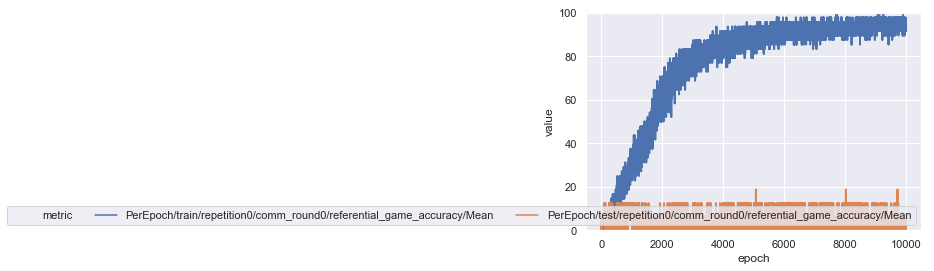

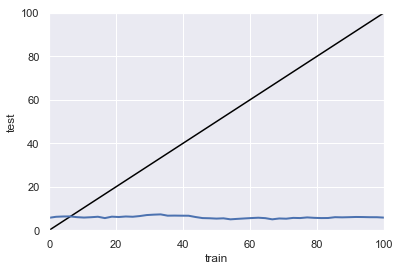

In [15]:
batch_size = 2
paths = {}
#paths[batch_size] = f"dSprites+DualLabeled/AttachedHeads/10000Ep_Emb256_CNN-1to128/TrainNOTF_TestNOTF/Dropout0.0_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial2-Y-4-2-X-4-2-Orientation-40-N-Scale-6-N-Shape-3-N/OBS32X1C-Rep1-S1L1-None-ResetoldestL-CulturalAgent-SEED0-partial-obs_b{batch_size}_minib128_lr0.0001-straight_through_gumbel_softmax-tau0-0.2-uniformDistrTrain47Test63-stim1-vocab100over20_BN+Coord4CNN3x3/adam/withPopulationHandlerModule/STGS-Baseline-LSTM-CNN-Agent/Periodic20TS+DISComp-/NoAnalogyTest/DatasetRepTrain1Test1"
paths[batch_size] = f"dSprites+DualLabeled/AttachedHeads/10000Ep_Emb256_CNN-1to128/TrainNOTF_TestNOTF/Dropout0.0_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial2-Y-4-S4-X-4-S4-Orientation-40-N-Scale-6-N-Shape-3-N/OBS32X1C-Rep1-S1L1-None-ResetoldestL-CulturalAgent-SEED0-partial-obs_b{batch_size}_minib128_lr0.0001-straight_through_gumbel_softmax-tau0-0.2-uniformDistrTrain47Test63-stim1-vocab100over20_BN+CNN3x3/adam/withPopulationHandlerModule/STGS-Baseline-LSTM-CNN-Agent/Periodic20TS+DISComp-/NoAnalogyTest/DatasetRepTrain1Test1"
g_accs = {}
df_runs_dict = {}
g_accs[batch_size], df_runs_dict[batch_size] = glob_filter_draw_acc4path(paths[batch_size], nbr_epochs=-1)

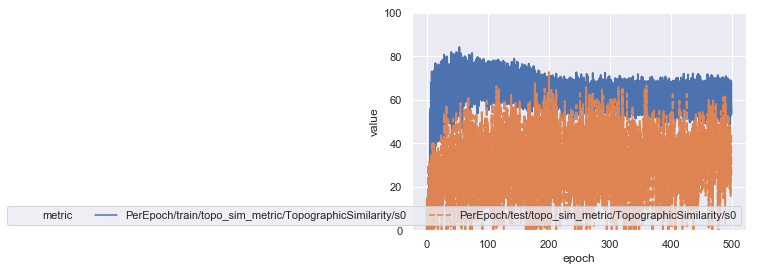

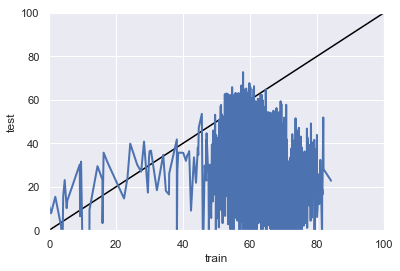

In [16]:
g_tvt_TSs = {}
g_tvt_TSs[batch_size] = filtered_graph(df_runs_dict[batch_size],
    filtering_keys=[
        "PerEpoch/test/topo_sim_metric/TopographicSimilarity/s0", 
        "PerEpoch/train/topo_sim_metric/TopographicSimilarity/s0"
    ], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    #hue="exp",
    style="metric",
    percentage=True,
    nbr_epochs=-1)

/scratch/staff/kyd500/development/MineRL/ReferentialGym/zoo/referential-games+st-gs/dSprites+DualLabeled/AttachedHeads/10000Ep_Emb256_CNN-1to128/TrainNOTF_TestNOTF/Dropout0.0_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial2-Y-4-S4-X-4-S4-Orientation-40-N-Scale-6-N-Shape-3-N/OBS32X1C-Rep1-S1L1-None-ResetoldestL-CulturalAgent-SEED30-partial-obs_b12_minib128_lr0.0001-straight_through_gumbel_softmax-tau0-0.2-uniformDistrTrain47Test63-stim1-vocab100over20_BN+CNN3x3/adam/withPopulationHandlerModule/STGS-Baseline-LSTM-CNN-Agent/Periodic20TS+DISComp-/NoAnalogyTest/DatasetRepTrain1Test1/events.out.tfevents.1589579283.csgpu2.cs.york.ac.uk
--------------------
/scratch/staff/kyd500/development/MineRL/ReferentialGym/zoo/referential-games+st-gs/dSprites+DualLabeled/AttachedHeads/10000Ep_Emb256_CNN-1to128/TrainNOTF_TestNOTF/Dropout0.0_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial2-Y-4-S4-X-4-S4-Orientation-40-N-Scale-6-N-Shape-3-N/OBS32X1C-Rep1-S1L1-None-ResetoldestL-CulturalAgent-SEED40-parti

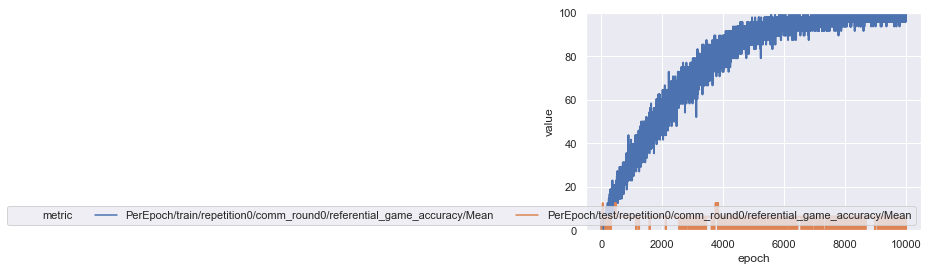

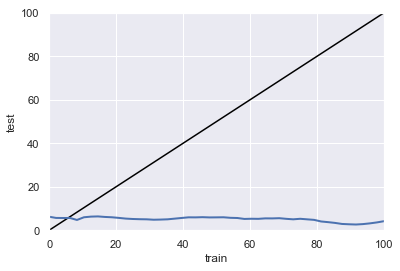

In [17]:
batch_size = 12
paths[batch_size] = f"dSprites+DualLabeled/AttachedHeads/10000Ep_Emb256_CNN-1to128/TrainNOTF_TestNOTF/Dropout0.0_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial2-Y-4-S4-X-4-S4-Orientation-40-N-Scale-6-N-Shape-3-N/OBS32X1C-Rep1-S1L1-None-ResetoldestL-CulturalAgent-SEED0-partial-obs_b{batch_size}_minib128_lr0.0001-straight_through_gumbel_softmax-tau0-0.2-uniformDistrTrain47Test63-stim1-vocab100over20_BN+CNN3x3/adam/withPopulationHandlerModule/STGS-Baseline-LSTM-CNN-Agent/Periodic20TS+DISComp-/NoAnalogyTest/DatasetRepTrain1Test1"
g_accs[batch_size], df_runs_dict[batch_size] = glob_filter_draw_acc4path(paths[batch_size], nbr_epochs=-1)

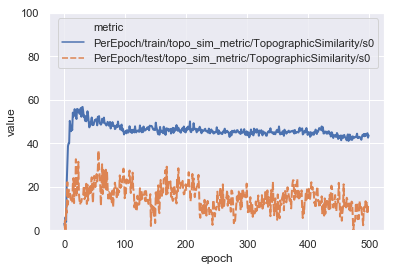

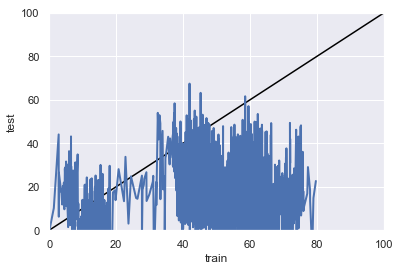

In [17]:
batch_size = 12
g_tvt_TSs[batch_size] = filtered_graph(df_runs_dict[batch_size],
    filtering_keys=[
        "PerEpoch/test/topo_sim_metric/TopographicSimilarity/s0", 
        "PerEpoch/train/topo_sim_metric/TopographicSimilarity/s0"
    ], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    #hue="exp",
    style="metric",
    percentage=True,
    nbr_epochs=-1)

/scratch/staff/kyd500/development/MineRL/ReferentialGym/zoo/referential-games+st-gs/dSprites+DualLabeled/AttachedHeads/10000Ep_Emb256_CNN-1to128/TrainNOTF_TestNOTF/Dropout0.0_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial2-Y-4-S4-X-4-S4-Orientation-40-N-Scale-6-N-Shape-3-N/OBS32X1C-Rep1-S1L1-None-ResetoldestL-CulturalAgent-SEED30-partial-obs_b24_minib128_lr0.0001-straight_through_gumbel_softmax-tau0-0.2-uniformDistrTrain47Test63-stim1-vocab100over20_BN+CNN3x3/adam/withPopulationHandlerModule/STGS-Baseline-LSTM-CNN-Agent/Periodic20TS+DISComp-/NoAnalogyTest/DatasetRepTrain1Test1/events.out.tfevents.1589796591.csgpu2.cs.york.ac.uk
--------------------
/scratch/staff/kyd500/development/MineRL/ReferentialGym/zoo/referential-games+st-gs/dSprites+DualLabeled/AttachedHeads/10000Ep_Emb256_CNN-1to128/TrainNOTF_TestNOTF/Dropout0.0_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial2-Y-4-S4-X-4-S4-Orientation-40-N-Scale-6-N-Shape-3-N/OBS32X1C-Rep1-S1L1-None-ResetoldestL-CulturalAgent-SEED40-parti

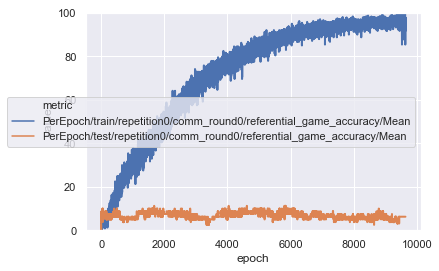

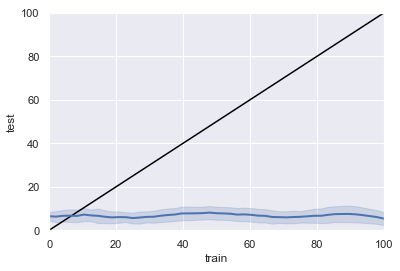

In [15]:
batch_size = 24
paths[batch_size] = f"dSprites+DualLabeled/AttachedHeads/10000Ep_Emb256_CNN-1to128/TrainNOTF_TestNOTF/Dropout0.0_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial2-Y-4-S4-X-4-S4-Orientation-40-N-Scale-6-N-Shape-3-N/OBS32X1C-Rep1-S1L1-None-ResetoldestL-CulturalAgent-SEED0-partial-obs_b{batch_size}_minib128_lr0.0001-straight_through_gumbel_softmax-tau0-0.2-uniformDistrTrain47Test63-stim1-vocab100over20_BN+CNN3x3/adam/withPopulationHandlerModule/STGS-Baseline-LSTM-CNN-Agent/Periodic20TS+DISComp-/NoAnalogyTest/DatasetRepTrain1Test1"
g_accs[batch_size], df_runs_dict[batch_size] = glob_filter_draw_acc4path(paths[batch_size], nbr_epochs=-1)

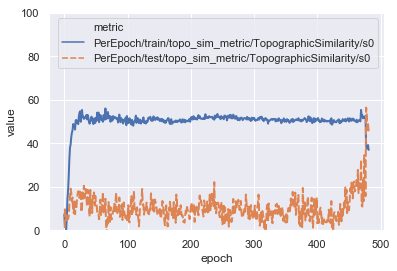

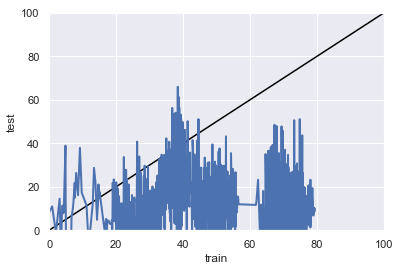

In [18]:
batch_size = 24
g_tvt_TSs[batch_size] = filtered_graph(df_runs_dict[batch_size],
    filtering_keys=[
        "PerEpoch/test/topo_sim_metric/TopographicSimilarity/s0", 
        "PerEpoch/train/topo_sim_metric/TopographicSimilarity/s0"
    ], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    #hue="exp",
    style="metric",
    percentage=True,
    nbr_epochs=-1)

/scratch/staff/kyd500/development/MineRL/ReferentialGym/zoo/referential-games+st-gs/dSprites+DualLabeled/AttachedHeads/10000Ep_Emb256_CNN-1to128/TrainNOTF_TestNOTF/Dropout0.0_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial2-Y-4-S4-X-4-S4-Orientation-40-N-Scale-6-N-Shape-3-N/OBS32X1C-Rep1-S1L1-None-ResetoldestL-CulturalAgent-SEED0-partial-obs_b36_minib128_lr0.0001-straight_through_gumbel_softmax-tau0-0.2-uniformDistrTrain47Test63-stim1-vocab100over20_BN+CNN3x3/adam/withPopulationHandlerModule/STGS-Baseline-LSTM-CNN-Agent/Periodic20TS+DISComp-/NoAnalogyTest/DatasetRepTrain1Test1/events.out.tfevents.1589796644.csgpu2.cs.york.ac.uk
--------------------
/scratch/staff/kyd500/development/MineRL/ReferentialGym/zoo/referential-games+st-gs/dSprites+DualLabeled/AttachedHeads/10000Ep_Emb256_CNN-1to128/TrainNOTF_TestNOTF/Dropout0.0_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial2-Y-4-S4-X-4-S4-Orientation-40-N-Scale-6-N-Shape-3-N/OBS32X1C-Rep1-S1L1-None-ResetoldestL-CulturalAgent-SEED20-partia

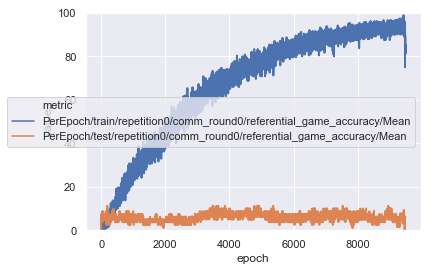

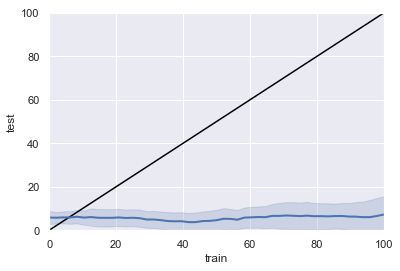

In [16]:
batch_size = 36
paths[batch_size] = f"dSprites+DualLabeled/AttachedHeads/10000Ep_Emb256_CNN-1to128/TrainNOTF_TestNOTF/Dropout0.0_DPEmb0.8_BN_learning/Hinge/dSprites-combinatorial2-Y-4-S4-X-4-S4-Orientation-40-N-Scale-6-N-Shape-3-N/OBS32X1C-Rep1-S1L1-None-ResetoldestL-CulturalAgent-SEED0-partial-obs_b{batch_size}_minib128_lr0.0001-straight_through_gumbel_softmax-tau0-0.2-uniformDistrTrain47Test63-stim1-vocab100over20_BN+CNN3x3/adam/withPopulationHandlerModule/STGS-Baseline-LSTM-CNN-Agent/Periodic20TS+DISComp-/NoAnalogyTest/DatasetRepTrain1Test1"
g_accs[batch_size], df_runs_dict[batch_size] = glob_filter_draw_acc4path(paths[batch_size], nbr_epochs=-1)

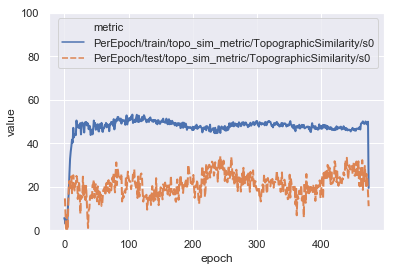

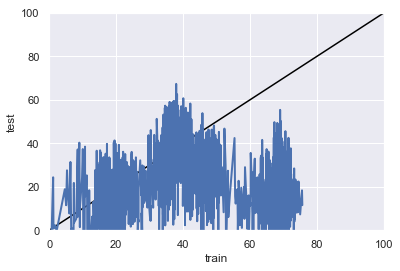

In [19]:
batch_size = 36
g_tvt_TSs[batch_size] = filtered_graph(df_runs_dict[batch_size],
    filtering_keys=[
        "PerEpoch/test/topo_sim_metric/TopographicSimilarity/s0", 
        "PerEpoch/train/topo_sim_metric/TopographicSimilarity/s0"
    ], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    #hue="exp",
    style="metric",
    percentage=True,
    nbr_epochs=-1)

In [20]:
run_lengths = {key:len(df_runs_dict[key]['value']) for key in df_runs_dict.keys()}
df_runs_dict_id = {key:df.assign(exp=pd.Series([f"batch={key}"]*run_lengths[key])) for key, df in df_runs_dict.items()}

combined_df = pd.concat(df_runs_dict_id.values())
                                         
for metric in set(combined_df['metric']):
    print(metric)

PerEpoch/train/topo_sim_metric/FeaturesTopographicSimilarity/s0
PerEpoch/test/repetition0/comm_round0/Tau/s0/Median
PerEpoch/train/repetition0/comm_round0/referential_game_loss/Median
PerEpoch/train/listener_factor_vae_disentanglement_metric/DisentanglementMetric/FactorVAE/train_accuracy
PerEpoch/train/listener_factor_vae_disentanglement_metric/DisentanglementMetric/FactorVAE/eval_accuracy/factor_5
PerEpoch/train/listener_factor_vae_disentanglement_metric/DisentanglementMetric/FactorVAE/eval_accuracy/factor_1
PerEpoch/train/repetition0/comm_round0/Loss
PerEpoch/train/repetition0/comm_round0/s0/SentenceLength__/20_/Mean
PerEpoch/train/repetition0/comm_round0/Loss/Q3
PerEpoch/train/repetition0/comm_round0/referential_game_loss
PerEpoch/test/listener_factor_vae_disentanglement_metric/DisentanglementMetric/FactorVAE/eval_accuracy/factor_3
PerEpoch/train/repetition0/comm_round0/referential_game_loss/Std
train/repetition0/comm_round0/referential_game_accuracy
PerEpoch/train/speaker_factor_va

### CNN-based architectures: Ability to generalize compositionally to novel compositional stimuli with familiar components

singular matrix
singular matrix


/home/kevin/anaconda3/envs/RG/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


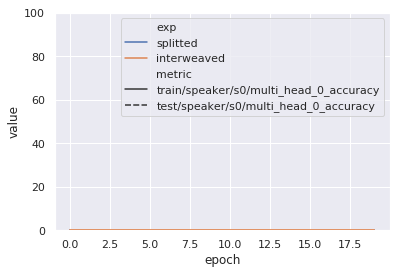

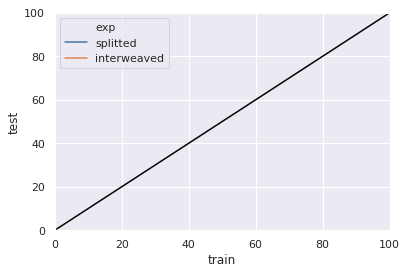

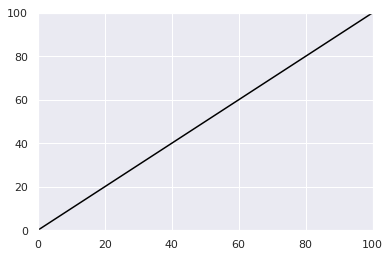

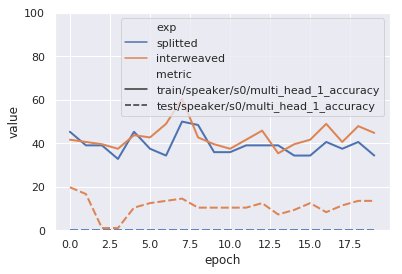

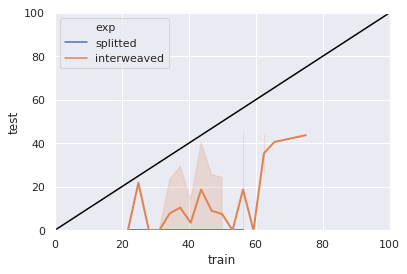

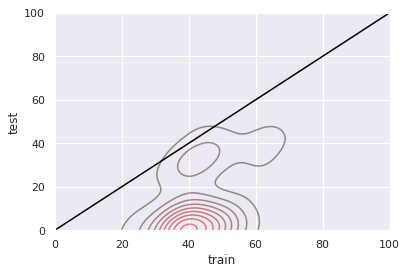

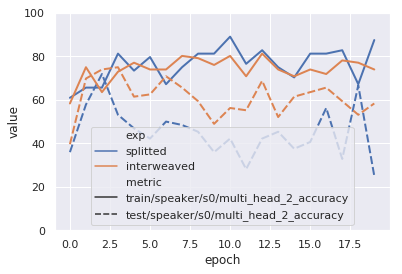

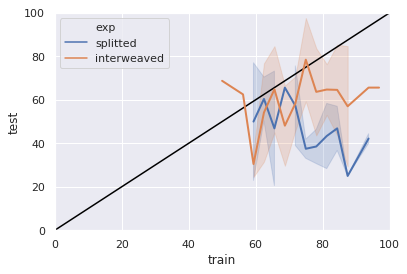

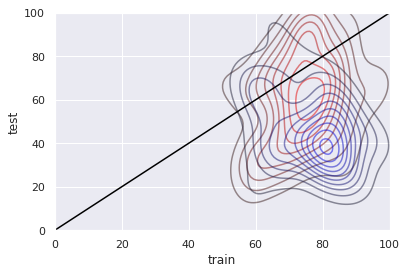

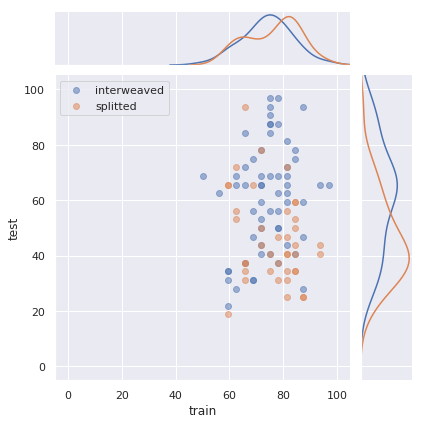

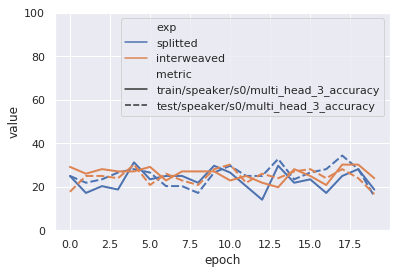

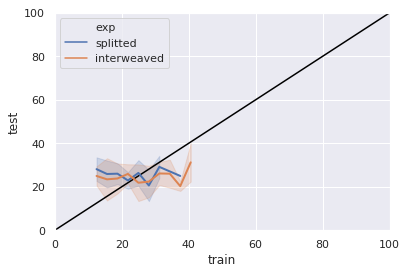

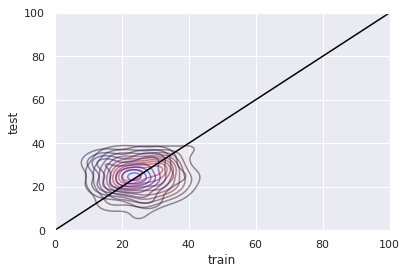

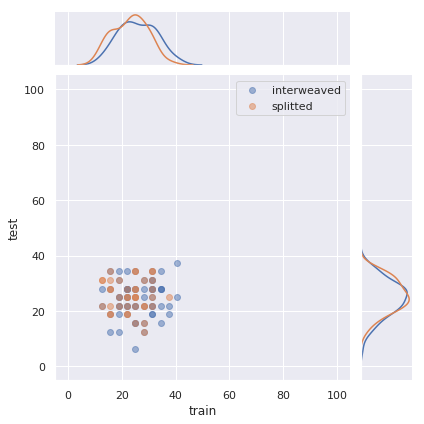

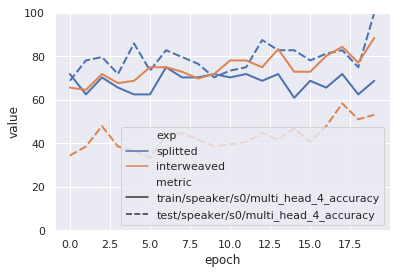

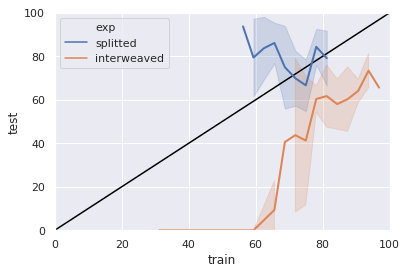

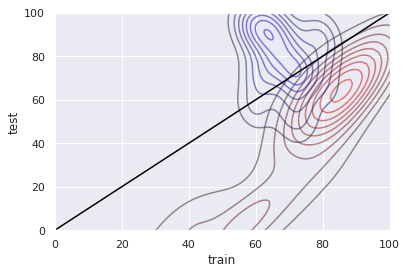

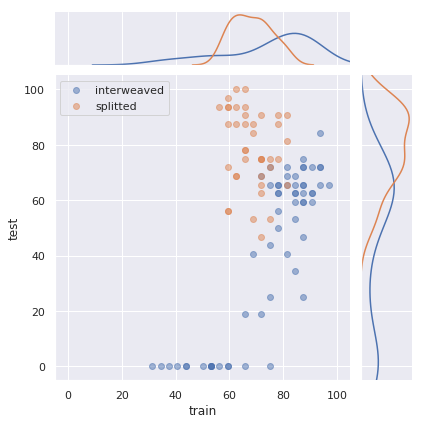

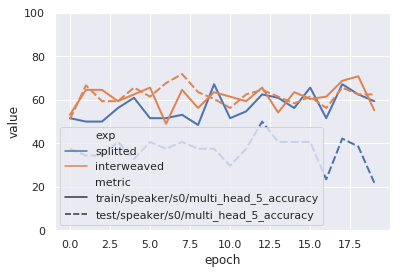

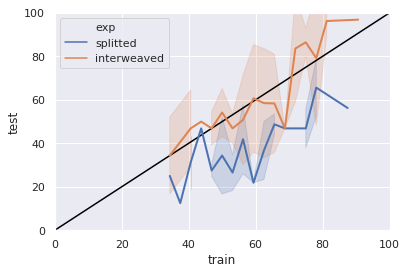

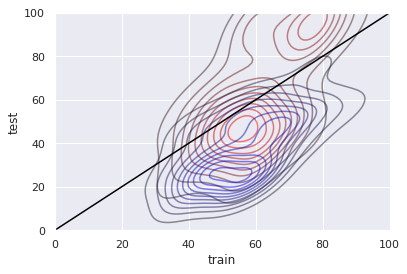

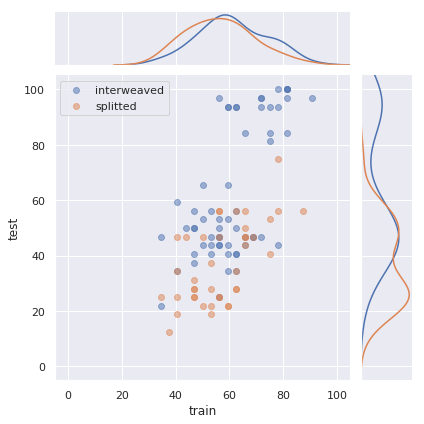

In [173]:
# g_test_LatentPrediction_split_vs_inter = {}
# for i_head in range(6):
#     g_test_LatentPrediction_split_vs_inter[i_head] = filtered_graph(pd.concat([df_runs_split_id, df_runs_inter_id]),
#                    filtering_keys=[f"test/speaker/s0/multi_head_{i_head}_accuracy", f"train/speaker/s0/multi_head_{i_head}_accuracy"], 
#                    logscale=False,
#                    ci='sd',
#                    err_style='band',
#                    linewidth=2,
#                    hue="exp",
#                    style="metric",
#                    percentage=True)

#### Details of the benchmark:

Zero-shot learning to compositional stimuli with familiar components is benchmarked here by removing stimuli of the form "ANY_COLOR | Heart | ANY_SCALE | ANY_ORIENTATION | X_in_{} | Y_in_{}" where X_in_{} and Y_in_{} depend on the train/test split.

In the 'splitted' split, POS_in_{} corresponds to all the position on the top left corner of the image, whereas in the 'interweaved' split, it corresponds to regularly spaced out positions throughout the whole image.

#### Results:

Despite the fact that the position-related latents are not showing much variations between the train and the test results --thus hinting at the fact that (maybe?) CNN-based architecture are able to generalize compositionally to that kind of variation (more on this later: idea that it might just be that they have had enough examples to do so, and/or that they do have the relevant biases to do so + factoring the fact that this is only a probe to what the CNN has learned so far using the RG loss function!!!!! + factoring the fact that the data-density of each value is different from one latent axis to another, i.e. only 3 values are seen on the SHAPE axis, while as much as 8 values are seen on the individual X/Y axises / 64 on the position axis!!!!)--, it is clear that a different story is being laid out with the SHAPE latent:

- (i) None of the train/test split achieved similar test accuracies than at training time, thus argumenting for the fact that this CNN-based architecture fails to generalize compositionally to component of SHAPE (object-type?), in this very limited setting.
- (ii) This kind of CNN-based architecture is only able to get itself off the ground when paired up with an 'interweaved' train/test split pattern, that shows a simpler kind of zero-shot learning [...] than in the case of 'splitted' split.

### Effect on Referential Game's Accuracy and Compositionality:

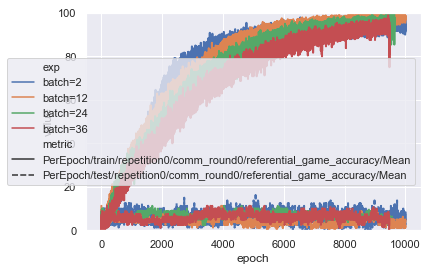

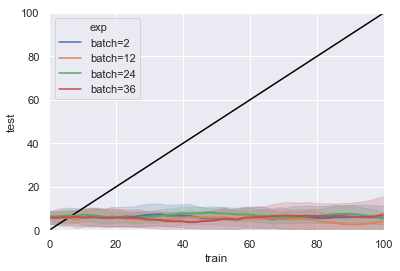

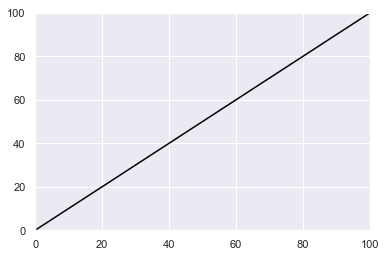

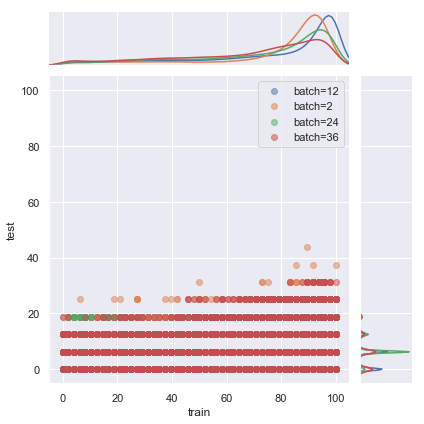

In [21]:
g_tvt_acc_combined = filtered_graph(combined_df,
    #filtering_keys=["test/Accuracy", "train/Accuracy"], 
    filtering_keys=[
        'PerEpoch/test/repetition0/comm_round0/referential_game_accuracy/Mean', 
        'PerEpoch/train/repetition0/comm_round0/referential_game_accuracy/Mean'
    ], 
    logscale=False,
    ci='sd',
    err_style='band',
    linewidth=2,
    hue="exp",
    style="metric",
    percentage=True,
    nbr_epochs=-1)

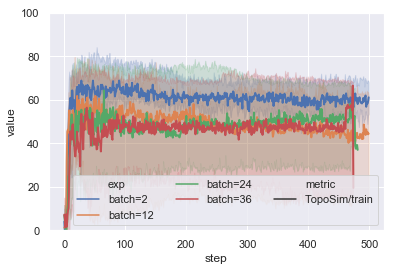

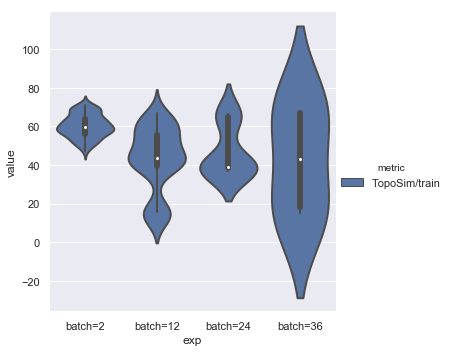

In [70]:
g_tvt_TS_combined, g_violin_tvt_TS_combined = filtered_graph(combined_df,
    filtering_keys=[
        #"PerEpoch/test/topo_sim_metric/TopographicSimilarity/s0", 
        "PerEpoch/train/topo_sim_metric/TopographicSimilarity/s0"
    ], 
    logscale=False,
    ci=None,#'sd',
    err_style='band',
    linewidth=2,
    hue="exp",
    style="metric",
    percentage=True,
    nbr_epochs=-1,
    to_replace={
        #"PerEpoch/test/topo_sim_metric/TopographicSimilarity/s0":"TopoSim/test", 
        "PerEpoch/train/topo_sim_metric/TopographicSimilarity/s0":"TopoSim/train"
    },
    do_violin_plot=True,
    focus_quartile=0.97)

# g_test_TS_split_vs_inter = filtered_graph(combined_df_runs_inter_split,
#     filtering_keys=["test/s0/TopographicSimilarity", "train/s0/TopographicSimilarity"], 
#     logscale=False,
#     ci='sd',
#     err_style='band',
#     linewidth=2,
#     hue="exp",
#     style="metric",
#     percentage=False)

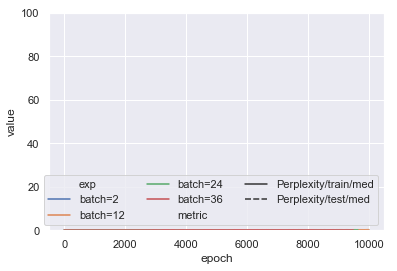

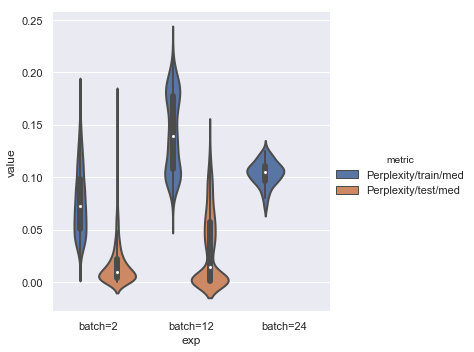

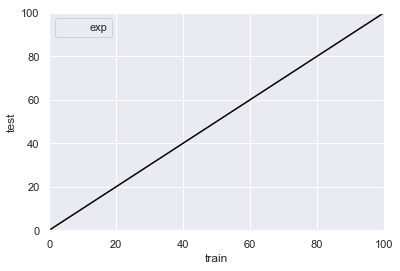

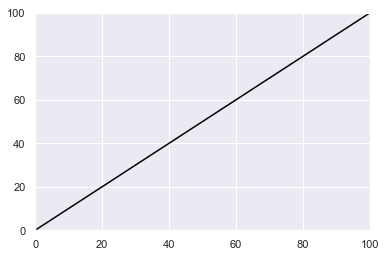

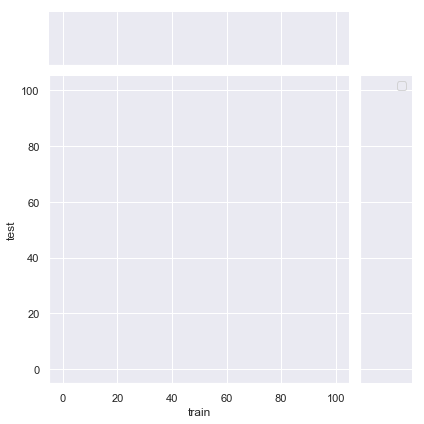

In [71]:
g_tvt_Perplexity_combined, ps, g_Perplexity_tvt_TS_combined = filtered_graph(combined_df,
    filtering_keys=[
        "PerEpoch/train/repetition0/comm_round0/s0/Entropy/Median", 
        "PerEpoch/test/repetition0/comm_round0/s0/Entropy/Median"
    ], 
    logscale=False,
    ci=None,#'sd',
    err_style='band',
    linewidth=2,
    hue="exp",
    style="metric",
    percentage=True,
    nbr_epochs=-1,
    to_replace={
        "PerEpoch/test/repetition0/comm_round0/s0/Entropy/Median":"Perplexity/test/med", 
        "PerEpoch/train/repetition0/comm_round0/s0/Entropy/Median":"Perplexity/train/med"
    },
    do_violin_plot=True,
    focus_quartile=0.97)

# g_test_TS_split_vs_inter = filtered_graph(combined_df_runs_inter_split,
#     filtering_keys=["test/s0/TopographicSimilarity", "train/s0/TopographicSimilarity"], 
#     logscale=False,
#     ci='sd',
#     err_style='band',
#     linewidth=2,
#     hue="exp",
#     style="metric",
#     percentage=False)

#### Results:

- (i) The difference between the train and test time TS, in the 'splitted' setting, clearly shows the lack of productivity that the emerging I-language would enables (i.e. measure compositionality in terms of the ability, at test time, to repurpose the language to novel stimuli, thus yielding a high TS measure for the test-time E-Language).

- (ii) Focusing on the accuracies, it would seem that the emerging language in the 'interweaved' setting allows the agent to generalize compositionally **when it comes to discriminating between stimuli**.


### Why is there seemingly compositional generalization when looking at the RG accuracy, while there is failure to do so when looking at the latent values prediction?

It most likely has to do with the latent axises difference in terms of value sampling size. The sampling size on the SHAPE latent axis is far smaller than that on the POSITION latent axis, which gives the architecture less opportunity to learn to generalize, thus showing that they do not generalize systematically, but rather that they pile up evidences, similarly to how RNNs do(\cite{Loula et al. 2018}).
The accuracies observed are a reflexion of the language being focused more on positioning than on shapes.

To give a greater sense of this, we test the same architecture with test samples that consist solely of stimuli of the shape (SAME_COLOR | Shapes_in_{} | SAME_SCALE | SAME_ORIENTATION | SAME_X | SAME_Y).
